In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from xgboost import XGBClassifier

In [47]:
# def make_confusion_matrix(model, threshold=0.5):
#     y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
#     fraud_confusion = confusion_matrix(y_test, y_predict)
#     plt.figure(dpi=80)
#     sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
#            xticklabels=['legit', 'fraud'],
#            yticklabels=['legit', 'fraud']);
#     plt.xlabel('prediction')
#     plt.ylabel('actual')

In [ ]:
# import matplotlib.cm as cm

# def visualize(X, y, bdry='diag'):
#     c = cm.rainbow(np.linspace(0, 1, 2))
#     plt.scatter([i[0] for i in X], [i[1] for i in X], color=[c[i] for i in y], alpha=.5)
    
#     #Plot the true decision boundary
#     if bdry == 'diag':
#         plt.plot([0, 1], [0, 1], 'k--')
#     elif bdry == 'quadrant':
#         plt.plot([0, 1], [0.5, 0.5], 'k--')
#         plt.plot([0.5, 0.5], [0, 1], 'k--')
        
#     plt.grid(True)

In [ ]:
# def plot_features(df, sample_size=500):
    
#     sample = (df.drop(['product_id','user_id','latest_cart'],axis=1)
#                 .sample(1000, random_state=42)) 
#     sns.pairplot(sample,hue='in_cart', plot_kws=dict(alpha=.3, edgecolor='none'))

# plot_features(df_X1)

In [ ]:
# def get_user_split_data(df, test_size=.2, seed=42):

#     rs = np.random.RandomState(seed)
    
#     total_users = df['user_id'].unique() 
#     test_users = rs.choice(total_users, 
#                            size=int(total_users.shape[0] * test_size), 
#                            replace=False)

#     df_tr = df[~df['user_id'].isin(test_users)]
#     df_te = df[df['user_id'].isin(test_users)] 

#     y_tr, y_te = df_tr['in_cart'], df_te['in_cart']
#     X_tr = df_tr.drop(['product_id','user_id','latest_cart','in_cart'],axis=1) 
#     X_te = df_te.drop(['product_id','user_id','latest_cart','in_cart'],axis=1)

#     return X_tr, X_te, y_tr, y_te

In [2]:
default_df = pd.read_csv('../01_data_collection/cc_fraud/card_transdata.csv')

In [3]:
default_df.shape

(1000000, 8)

In [4]:
default_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [5]:
default_df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [6]:
default_df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


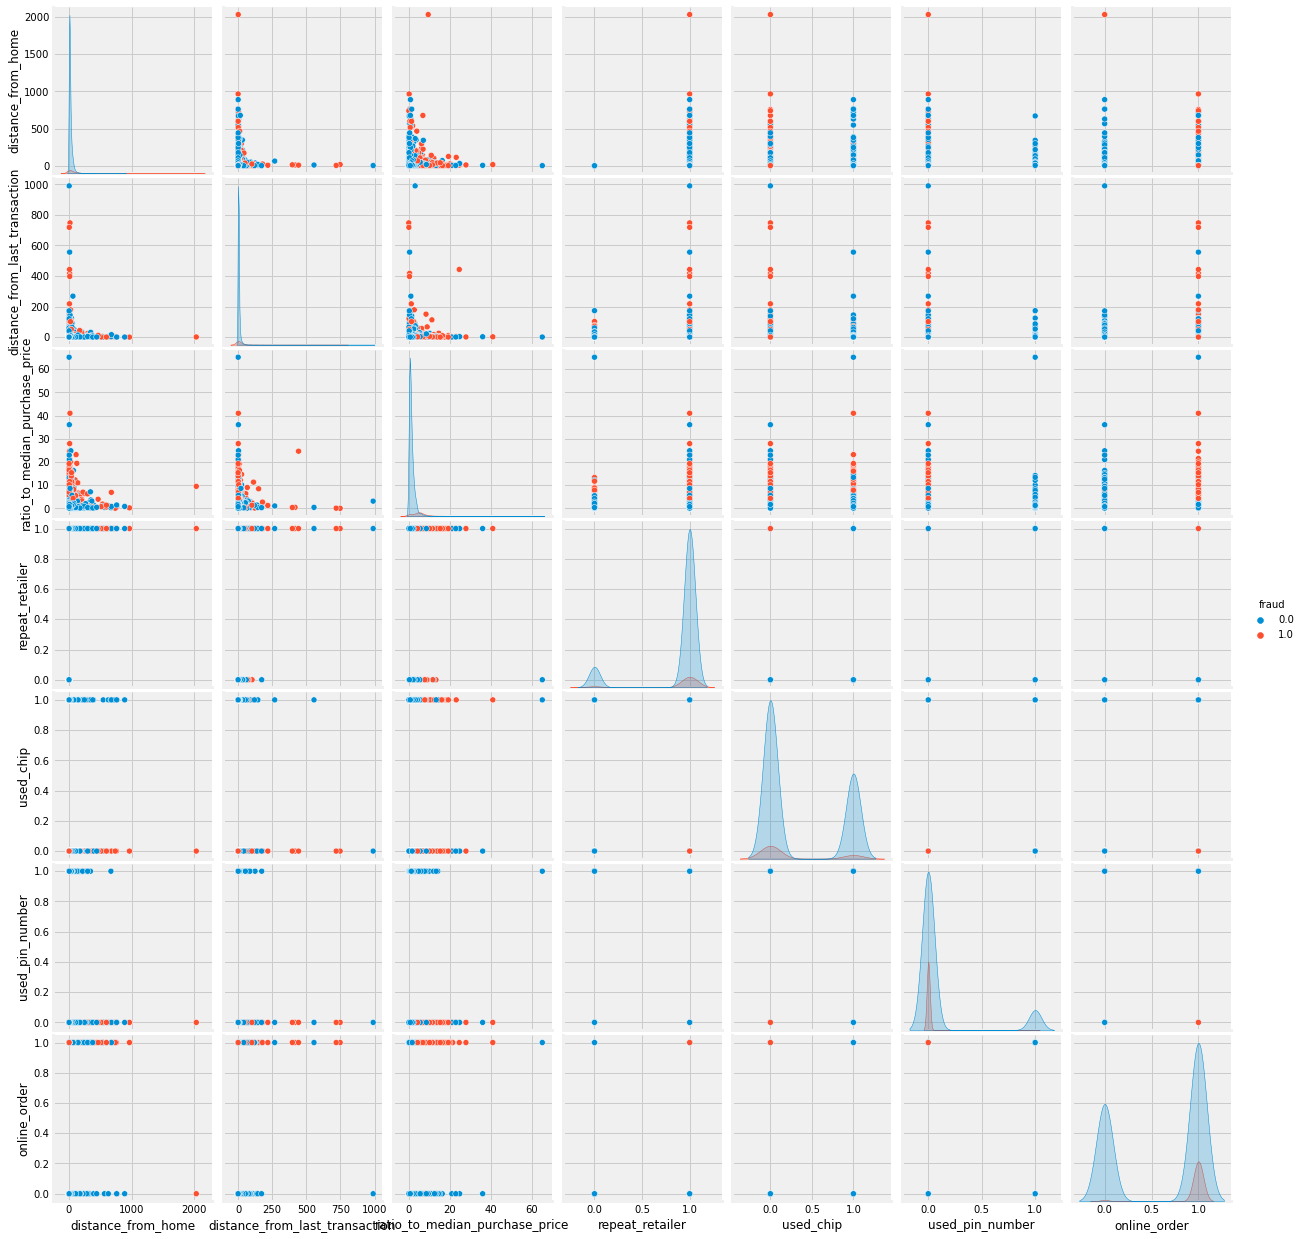

In [7]:
sample_df = default_df[0:5000]
sns.pairplot(sample_df, hue='fraud');

In [8]:
default_df['fraud'].value_counts()

0.0    912597
1.0     87403
Name: fraud, dtype: int64

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


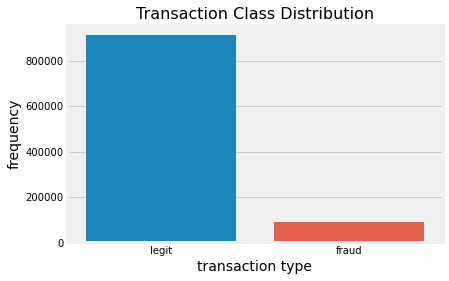

In [9]:
sns.countplot(default_df['fraud'])
labels = ['legit', 'fraud']
plt.title('Transaction Class Distribution',fontsize = 16)
plt.xticks(range(2), labels) 
plt.xlabel('transaction type', fontsize =14)
plt.ylabel('frequency', fontsize = 14);

In [10]:
X = default_df.drop(columns=['fraud'])
y = default_df['fraud']

In [11]:
X.shape

(1000000, 7)

In [12]:
y.shape

(1000000,)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
X_train.shape

(700000, 7)

In [15]:
# standardized scaling
std = StandardScaler()
std.fit(X_train.values)

X_train_scaled = std.transform(X_train.values)
X_test_scaled = std.transform(X_test.values)

In [16]:
# instantiate KNeighborsClassifier and fit
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [17]:
print('kNN Scores:' )

# knn accuracy score on train
print('Accuracy (train): ', knn.score(X_train_scaled,y_train))
print('Accuracy (test): ', knn.score(X_test_scaled,y_test))

# knn precision, recall, f1 (default threshold)
y_predict = knn.predict(X_test_scaled)
print('Precision: ', precision_score(y_test, y_predict))
print('Recall: ', recall_score(y_test, y_predict))
print('F1: ', f1_score(y_test, y_predict))

# knn regression log loss
y_prob_pred_train = knn.predict_proba(X_train_scaled)[:,1]
y_prob_pred_test = knn.predict_proba(X_test_scaled)[:,1]

print('Log Loss (train): ', log_loss(y_train,y_prob_pred_train))
print('Log Loss (test): ', log_loss(y_test,y_prob_pred_test))

kNN Scores:
Accuracy (train):  0.9993614285714286
Accuracy (test):  0.99869
Precision:  0.9949992306508694
Recall:  0.9899345554747598
F1:  0.9924604316546762
Log Loss on train:  0.0018854812089996813
Log Loss on test:  0.005157619651169548


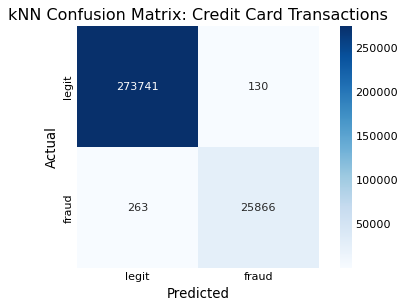

In [18]:
# knn confusion matrix
knn_confusion = confusion_matrix(y_test, knn.predict(X_test_scaled))
plt.figure(dpi=80)
sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['legit', 'fraud'],
           yticklabels=['legit', 'fraud'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('kNN Confusion Matrix: Credit Card Transactions');

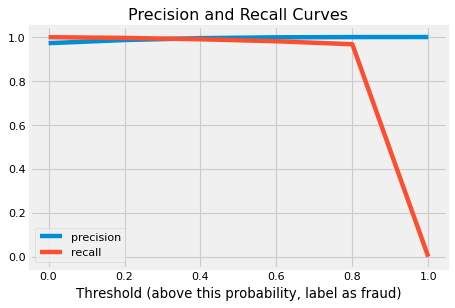

In [20]:
# knn precision-recall curve
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, knn.predict_proba(X_test_scaled)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

ROC AUC score =  0.9996511820017853


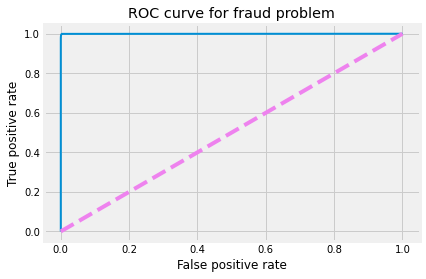

In [21]:
# knn ROC curve
fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test_scaled)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(y_test, knn.predict_proba(X_test_scaled)[:,1]))

In [22]:
# instantiate LogisticRegression and fit (all features)
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

LogisticRegression()

In [23]:
print('Logistic Regression Scores:' )

# logistic regression accuracy score
print('Accuracy (train): ', logreg.score(X_train_scaled,y_train))
print('Accuracy (test): ', logreg.score(X_test_scaled,y_test))


# logistic regression precision, recall, f1 (default threshold)
y_predict = logreg.predict(X_test_scaled)
print('Precision: ', precision_score(y_test, y_predict))
print('Recall: ', recall_score(y_test, y_predict))
print('F1: ', f1_score(y_test, y_predict))

# logisitic regression log loss
y_prob_pred_train = logreg.predict_proba(X_train_scaled)[:,1]
y_prob_pred_test = logreg.predict_proba(X_test_scaled)[:,1]

print('Log Loss (train): ', log_loss(y_train,y_prob_pred_train))
print('Log Loss (test): ', log_loss(y_test,y_prob_pred_test))

Logistic Regression Scores:
Accuracy (train):  0.9590928571428572
Accuracy (test):  0.95862
Precision:  0.8888573858803516
Recall:  0.5999081480347507
F1:  0.7163421990677269
Log Loss (train):  0.1338455122316742
Log Loss (test):  0.1346321733206216


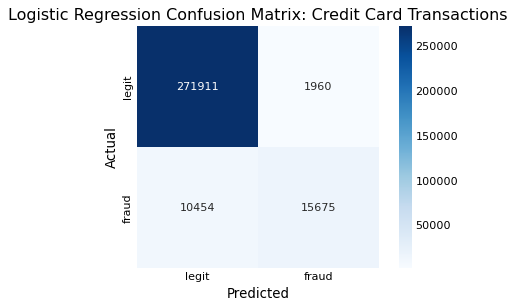

In [24]:
# logistic regression confusion matrix
logreg_confusion = confusion_matrix(y_test, logreg.predict(X_test_scaled))
plt.figure(dpi=80)
sns.heatmap(logreg_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['legit', 'fraud'],
           yticklabels=['legit', 'fraud'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix: Credit Card Transactions');

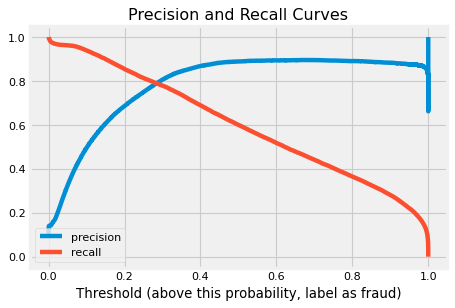

In [25]:
# logistic regression precision-recall curve
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, logreg.predict_proba(X_test_scaled)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

ROC AUC score =  0.9663789044916972


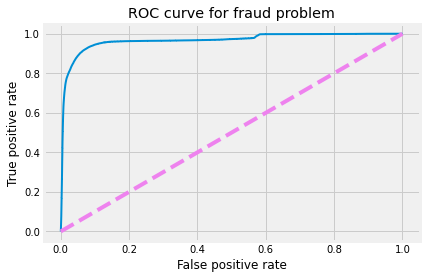

In [26]:
# logistic regression ROC curve
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_scaled)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(y_test, logreg.predict_proba(X_test_scaled)[:,1]))

In [27]:
# instantiate DecisionTreeClassifier and fit (all features)
decisiontree = DecisionTreeClassifier()
decisiontree.fit(X_train_scaled, y_train)

DecisionTreeClassifier()

In [28]:
print('Decision Tree Scores:' )

# decision tree accuracy score
print('Accuracy (train): ', decisiontree.score(X_train_scaled,y_train))
print('Accuracy (test): ', decisiontree.score(X_test_scaled,y_test))


# decision tree precision, recall, f1 (default threshold)
y_predict = decisiontree.predict(X_test_scaled)
print('Precision: ', precision_score(y_test, y_predict))
print('Recall: ', recall_score(y_test, y_predict))
print('F1: ', f1_score(y_test, y_predict))

# ldecision tree log loss
y_prob_pred_train = decisiontree.predict_proba(X_train_scaled)[:,1]
y_prob_pred_test = decisiontree.predict_proba(X_test_scaled)[:,1]

print('Log Loss (train): ', log_loss(y_train,y_prob_pred_train))
print('Log Loss (test): ', log_loss(y_test,y_prob_pred_test))

Decision Tree Scores:
Accuracy (train):  1.0
Accuracy (test):  0.99999
Precision:  0.9999617268830373
Recall:  0.9999234566956255
F1:  0.9999425914231586
Log Loss (train):  9.99200722162641e-16
Log Loss (test):  0.0003453904292748733


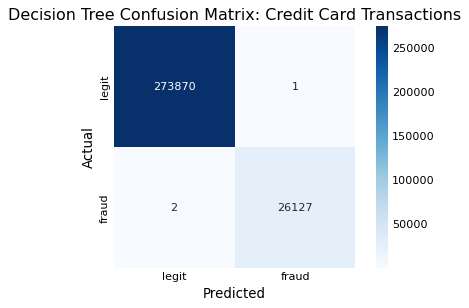

In [29]:
# decsion tree confusion matrix
decisiontree_confusion = confusion_matrix(y_test, decisiontree.predict(X_test_scaled))
plt.figure(dpi=80)
sns.heatmap(decisiontree_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['legit', 'fraud'],
           yticklabels=['legit', 'fraud'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Confusion Matrix: Credit Card Transactions');

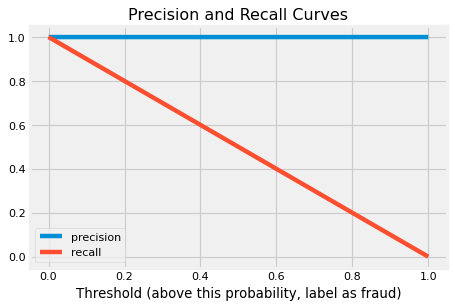

In [30]:
# decision tree precision-recall curve
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, decisiontree.predict_proba(X_test_scaled)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

ROC AUC score =  0.9999599026707605


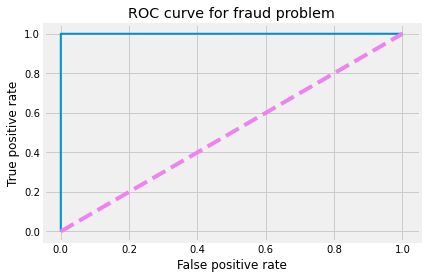

In [31]:
# decision tree ROC curve
fpr, tpr, thresholds = roc_curve(y_test, decisiontree.predict_proba(X_test_scaled)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(y_test, decisiontree.predict_proba(X_test_scaled)[:,1]))

In [32]:
# instantiate RandomForestClassifier and fit (all features)
randomforest = RandomForestClassifier()
randomforest.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [33]:
print('Random Forest Scores:' )

# random forest accuracy score
print('Accuracy (train): ', randomforest.score(X_train_scaled,y_train))
print('Accuracy (test): ', randomforest.score(X_test_scaled,y_test))


# random forest precision, recall, f1 (default threshold)
y_predict = randomforest.predict(X_test_scaled)
print('Precision: ', precision_score(y_test, y_predict))
print('Recall: ', recall_score(y_test, y_predict))
print('F1: ', f1_score(y_test, y_predict))

# lrandom forest log loss
y_prob_pred_train = randomforest.predict_proba(X_train_scaled)[:,1]
y_prob_pred_test = randomforest.predict_proba(X_test_scaled)[:,1]

print('Log Loss (train): ', log_loss(y_train,y_prob_pred_train))
print('Log Loss (test): ', log_loss(y_test,y_prob_pred_test))

Random Forest Scores:
Accuracy (train):  1.0
Accuracy (test):  0.99999
Precision:  1.0
Recall:  0.9998851850434384
F1:  0.9999425892259115
Log Loss on train:  0.00010441136354495496
Log Loss on test:  0.0002945886678882968


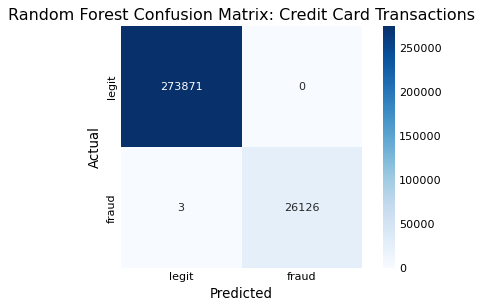

In [34]:
# random forest confusion matrix
randomforest_confusion = confusion_matrix(y_test, randomforest.predict(X_test_scaled))
plt.figure(dpi=80)
sns.heatmap(randomforest_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['legit', 'fraud'],
           yticklabels=['legit', 'fraud'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix: Credit Card Transactions');

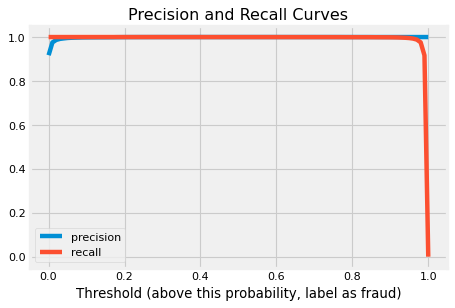

In [35]:
# random forest precision-recall curve
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, randomforest.predict_proba(X_test_scaled)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

ROC AUC score =  0.9999999997205133


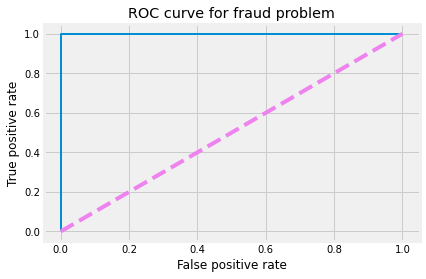

In [36]:
# random forest ROC curve
fpr, tpr, thresholds = roc_curve(y_test, randomforest.predict_proba(X_test_scaled)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(y_test, randomforest.predict_proba(X_test_scaled)[:,1]))

In [37]:
# instantiate XGBClassifier and fit (all features)
xgb = XGBClassifier(
                    objective='binary:logistic', 
                    n_estimators=100, 
                    learning_rate=0.5, 
                    )
# max_depth
# nthread
# colsample_bytree
# min_child_weight

xgb.fit(X_train_scaled, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.5, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [38]:
print('XGBoost Scores:' )

# xgb accuracy score
print('Accuracy (train): ', xgb.score(X_train_scaled,y_train))
print('Accuracy (test): ', xgb.score(X_test_scaled,y_test))


# xgb precision, recall, f1 (default threshold)
y_predict = xgb.predict(X_test_scaled)
print('Precision: ', precision_score(y_test, y_predict))
print('Recall: ', recall_score(y_test, y_predict))
print('F1: ', f1_score(y_test, y_predict))

# lxgb log loss
y_prob_pred_train = xgb.predict_proba(X_train_scaled)[:,1].astype(np.float64)
y_prob_pred_test = xgb.predict_proba(X_test_scaled)[:,1].astype(np.float64)

print('Log Loss (train): ', log_loss(y_train,y_prob_pred_train))
print('Log Loss (test): ', log_loss(y_test,y_prob_pred_test))

XGBoost Scores:
Accuracy (train):  1.0
Accuracy (test):  0.99999
Precision:  0.9999617268830373
Recall:  0.9999234566956255
F1:  0.9999425914231586
Log Loss (train):  5.6855628353038614e-06
Log Loss (test):  7.685153710740925e-05


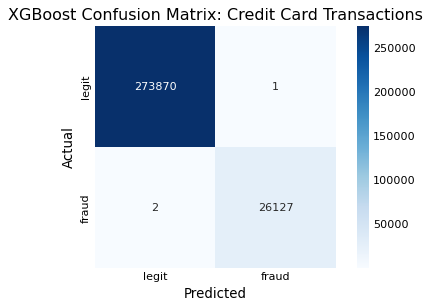

In [39]:
# XGBoost confusion matrix
xgb_confusion = confusion_matrix(y_test, xgb.predict(X_test_scaled))
plt.figure(dpi=80)
sns.heatmap(xgb_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['legit', 'fraud'],
           yticklabels=['legit', 'fraud'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix: Credit Card Transactions');

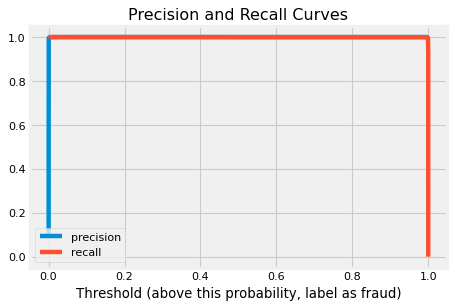

In [40]:
# xgb precision-recall curve
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, xgb.predict_proba(X_test_scaled)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

ROC AUC score =  0.9999999652039048


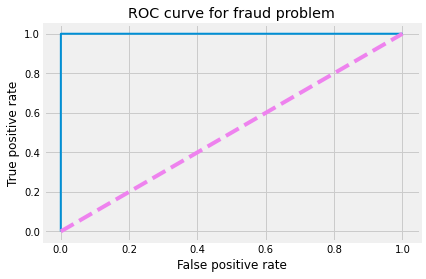

In [41]:
# xgb ROC curve
fpr, tpr, thresholds = roc_curve(y_test, xgb.predict_proba(X_test_scaled)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(y_test, xgb.predict_proba(X_test_scaled)[:,1]))

In [ ]:
## and the winner is: DecisionTreeClassifier

In [42]:
# decision tree feature importances before tuning/cross-validation
decisiontree.feature_importances_

array([0.09739853, 0.0343054 , 0.42375006, 0.01519012, 0.09021904,
       0.10342666, 0.23571018])

In [71]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('IMPORTANCE')
    plt.ylabel('FEATURE NAMES');

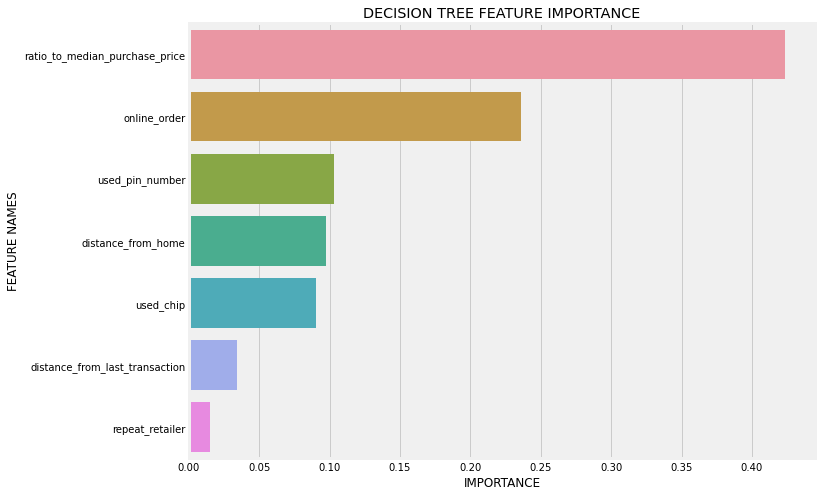

In [72]:
plot_feature_importance(decisiontree.feature_importances_,X_train.columns,'DECISION TREE')


In [43]:
# decision tree gridsearch cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

search_space = {'max_leaf_nodes': list(range(2,100)), 'min_samples_split':[2, 3, 4]}

decisiontree_gridsearch = GridSearchCV(estimator=decisiontree, param_grid=search_space,
                                       cv=kfold, n_jobs= -1, scoring='roc_auc', verbose=1)

decisiontree_gridsearch.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 294 candidates, totalling 1470 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             scoring='roc_auc', verbose=1)

In [51]:
print("Best estimator: ", decisiontree_gridsearch.best_estimator_)
print("Best score: ", decisiontree_gridsearch.best_score_)


Best estimator:  DecisionTreeClassifier(max_leaf_nodes=46, min_samples_split=3)
Best score:  0.9999177513037534


In [52]:
# instantiate DecisionTreeClassifier and fit (best parameters)
decisiontree = DecisionTreeClassifier(max_leaf_nodes=46, min_samples_split=3)
decisiontree.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_leaf_nodes=46, min_samples_split=3)

In [53]:
print('Decision Tree Scores:' )

# decision tree accuracy score
print('Accuracy (train): ', decisiontree.score(X_train_scaled,y_train))
print('Accuracy (test): ', decisiontree.score(X_test_scaled,y_test))


# decision tree precision, recall, f1 (default threshold)
y_predict = decisiontree.predict(X_test_scaled)
print('Precision: ', precision_score(y_test, y_predict))
print('Recall: ', recall_score(y_test, y_predict))
print('F1: ', f1_score(y_test, y_predict))

# ldecision tree log loss
y_prob_pred_train = decisiontree.predict_proba(X_train_scaled)[:,1]
y_prob_pred_test = decisiontree.predict_proba(X_test_scaled)[:,1]

print('Log Loss (train): ', log_loss(y_train,y_prob_pred_train))
print('Log Loss (test): ', log_loss(y_test,y_prob_pred_test))

Decision Tree Scores:
Accuracy (train):  1.0
Accuracy (test):  0.99999
Precision:  0.9999617268830373
Recall:  0.9999234566956255
F1:  0.9999425914231586
Log Loss (train):  9.99200722162641e-16
Log Loss (test):  0.0003453904292748733


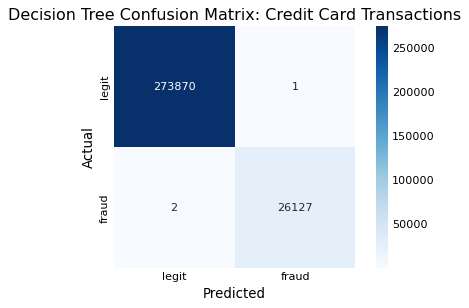

In [54]:
# decsion tree confusion matrix
decisiontree_confusion = confusion_matrix(y_test, decisiontree.predict(X_test_scaled))
plt.figure(dpi=80)
sns.heatmap(decisiontree_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['legit', 'fraud'],
           yticklabels=['legit', 'fraud'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Confusion Matrix: Credit Card Transactions');